<a id="eight"></a>
##  <p style="background-color:#070B19;font-family:TimesNewRoman;color:#81F7F3;font-size:100%;text-align:left;border-radius:15px 15px;padding:15px"> Feature Engineering (Silver), and Machine Learning (Stochastic Oscillator-based ML model
</p>

##### Imports

In [0]:
import pyspark.sql.functions as F
from pyspark.sql import SparkSession
from pyspark.sql.window import Window
from pyspark.sql.types import StructType, StructField, DoubleType, StringType
import numpy as np
import pandas as pd
import keras
from sklearn.preprocessing import MinMaxScaler

2025-06-09 00:27:28.088747: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-09 00:27:28.215335: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-09 00:27:28.317535: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-09 00:27:33.999785: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2025/06/09 00:27:36 WARNING mlflow.tracking.fluent: Exception raised while enabling autologging for tensorflow: cannot import name 'cast' from partially initialized module 'keras.src.backend' (most likely due to a circular import) (/databricks/python/lib/python3.11/site-packa

#####  <p style="background-color:#070B19;font-family:TimesNewRoman;color:#81F7F3;font-size:100%;text-align:left;border-radius:15px 15px;padding:15px"> Predefine Stocks DataFrame Schema </p>

In [0]:
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DecimalType, DoubleType, TimestampType, LongType

schema = StructType([
    StructField("ticker", StringType(), True),
    StructField("trade_volume", DecimalType(18, 2), True),
    StructField("volume_weighted_avg_price", DecimalType(18, 2), True),
    StructField("open_price", DecimalType(18, 2), True),
    StructField("close_price", DecimalType(18, 2), True),
    StructField("highest_price", DecimalType(18, 2), True),
    StructField("lowest_price", DecimalType(18, 2), True),
    StructField("timestamp_sec", TimestampType(), True),
    StructField("no_of_trans_aggr_window", LongType(), True)
])

#####  <p style="background-color:#070B19;font-family:TimesNewRoman;color:#81F7F3;font-size:100%;text-align:left;border-radius:15px 15px;padding:15px"> Load Stocks Data CSV into DataFrame ~ Silver </p>

In [0]:
# File location and type
file_location = "/FileStore/tables/silver_kafka_output_20250608_054406.csv"
file_type = "csv"

# CSV options
first_row_is_header = "true"
delimiter = ","

# Load the data using the predefined schema
silver_df = spark.read.format(file_type) \
    .option("header", first_row_is_header) \
    .option("sep", delimiter) \
    .schema(schema) \
    .load(file_location)

display(silver_df)

ticker,trade_volume,volume_weighted_avg_price,open_price,close_price,highest_price,lowest_price,timestamp_sec,no_of_trans_aggr_window
fx_CAUDZAR,424629486.00,177.13,192.24,182.01,192.87,159.70,2024-04-01T04:00:00Z,5725103
fx_CAUDZAR,375625499.00,172.40,182.20,154.59,196.95,154.02,2024-07-01T04:00:00Z,5253722
stocks_BA,8951574.00,182.73,178.09,184.57,186.01,178.02,2024-06-03T04:00:00Z,115959
stocks_BA,7176817.00,186.62,185.05,188.62,188.84,183.25,2024-06-04T04:00:00Z,99850
stocks_BA,5943952.00,188.95,187.90,189.85,190.34,186.53,2024-06-05T04:00:00Z,85202
stocks_BA,5942160.00,190.30,188.83,191.42,192.10,187.35,2024-06-06T04:00:00Z,77577
stocks_BA,3374548.00,190.59,190.46,190.24,191.98,189.66,2024-06-07T04:00:00Z,59599
stocks_BA,4388254.00,190.53,190.00,190.12,192.63,189.60,2024-06-10T04:00:00Z,63572
stocks_BA,5010058.00,185.29,189.32,185.50,189.32,182.75,2024-06-11T04:00:00Z,77065
stocks_BA,5245156.00,183.36,186.50,182.67,187.16,181.71,2024-06-12T04:00:00Z,80797


####  <p style="background-color:#070B19;font-family:TimesNewRoman;color:#81F7F3;font-size:100%;text-align:left;border-radius:15px 15px;padding:15px"> Stochastic Oscillator-based LSTM (Long Short-Term Memory) ML Model </p>

The **stochastic oscillator** helps traders spot **overbought** and **oversold conditions**, comparing the latest closing price to the overall price range over a set period (0-100 scale). It consists of two lines: **%K **(a fast, volatile indicator) and **%D **(a smoothed version using a moving average). Traders use these signals, along with divergence patterns, to predict market reversals and trend shifts.


The **LSTM** (Long Short-Term Memory) model is a type of recurrent neural network (RNN) designed to handle sequential data like stock prices, time series, or language processing. Unlike standard RNNs, LSTM can remember long-term patterns while avoiding issues like vanishing gradients, making it ideal for tracking dependencies over time.


#####  <p style="background-color:#070B19;font-family:TimesNewRoman;color:#81F7F3;font-size:100%;text-align:left;border-radius:15px 15px;padding:15px"> Compute Stochastic Oscillator (%K and %D) </p>

In [0]:
# Calculate %K and %D indicators using a rolling window:
# Define the rolling window for computing Stochastic Oscillator
window_spec = Window.orderBy("timestamp_sec").rowsBetween(-13, 0)

silver_df = silver_df.withColumn("LowestLow", F.min("lowest_price").over(window_spec))
silver_df = silver_df.withColumn("HighestHigh", F.max("highest_price").over(window_spec))
silver_df = silver_df.withColumn("%K", ((F.col("close_price") - F.col("LowestLow")) / (F.col("HighestHigh") - F.col("LowestLow"))) * 100)

silver_df = silver_df.withColumn("%D", F.avg("%K").over(window_spec))

display(silver_df)

ticker,trade_volume,volume_weighted_avg_price,open_price,close_price,highest_price,lowest_price,timestamp_sec,no_of_trans_aggr_window,LowestLow,HighestHigh,%K,%D
fx_CAUDZAR,424629486.00,177.13,192.24,182.01,192.87,159.70,2024-04-01T04:00:00Z,5725103,159.70,192.87,67.259571902321375,67.2595719023213750000
crypto_XBTCUSD,701239573.00,89.98,93.81,75.37,98.04,74.55,2024-04-01T04:00:00Z,7337586,74.55,192.87,0.693035835023665,33.9763038686725200000
stocks_BA,8951574.00,182.73,178.09,184.57,186.01,178.02,2024-06-03T04:00:00Z,115959,74.55,192.87,92.985125084516565,53.6459109406205350000
crypto_XBTCGBP,9668106.00,94.45,94.52,94.40,95.25,94.05,2024-06-03T04:00:00Z,91657,74.55,192.87,16.776538201487492,44.4285677558372742500
stocks_AAPL,183.00,94.96,94.94,94.94,94.94,94.94,2024-06-03T08:08:00Z,2,74.55,192.87,17.232927653820149,38.9894397354338492000
fx_CUSDZAR,183.00,94.96,94.94,94.94,94.94,94.94,2024-06-03T08:08:00Z,2,74.55,192.87,17.232927653820149,35.3633543884982325000
fx_CAEDUSD,389.00,178.46,178.49,178.49,178.49,178.49,2024-06-03T08:23:00Z,30,74.55,192.87,87.846517917511832,42.8609491783573181429
stocks_NKE,389.00,178.46,178.49,178.49,178.49,178.49,2024-06-03T08:23:00Z,30,74.55,192.87,87.846517917511832,48.4841452707516323750
fx_CAEDUSD,484.00,178.60,178.68,178.68,178.68,178.68,2024-06-03T08:30:00Z,27,74.55,192.87,88.007099391480730,52.8755846174993098889
stocks_NKE,484.00,178.60,178.68,178.68,178.68,178.68,2024-06-03T08:30:00Z,27,74.55,192.87,88.007099391480730,56.3887360948974519000


#####  <p style="background-color:#070B19;font-family:TimesNewRoman;color:#81F7F3;font-size:100%;text-align:left;border-radius:15px 15px;padding:15px"> Feature Engineering </p>

In [0]:
# Select relevant columns
feature_df = silver_df.select("close_price", "%K", "%D", "trade_volume")

# Convert PySpark DataFrame to Pandas
pandas_feature_df = feature_df.toPandas()

# Normalize the feature set
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(pandas_feature_df)

# Convert to feature vector format
X = scaled_features[:-1]  # Features
Y = scaled_features[1:, 0]  # Target: next-day closing price

/databricks/spark/python/pyspark/sql/pandas/utils.py:117: UserWarning: The conversion of DecimalType columns is inefficient and may take a long time. Column names: [close_price, %K, %D, trade_volume] If those columns are not necessary, you may consider dropping them or converting to primitive types before the conversion.
  warnings.warn(


#####  <p style="background-color:#070B19;font-family:TimesNewRoman;color:#81F7F3;font-size:100%;text-align:left;border-radius:15px 15px;padding:15px"> Save Processed Feature Vectors </p>


In [0]:
# Convert back to Spark DataFrame
feature_vector_df = spark.createDataFrame(pd.DataFrame(X))

# Save feature vector as Parquet in Databricks
feature_vector_df.write.mode("overwrite").parquet("dbfs:/user/hive/warehouse/silver.db/feature_vectors/")

#####  <p style="background-color:#070B19;font-family:TimesNewRoman;color:#81F7F3;font-size:100%;text-align:left;border-radius:15px 15px;padding:15px"> Split Dataset into Train, Validation, and Test Sets </p>


In [0]:
from sklearn.model_selection import train_test_split

# Define split ratios: 80% training, 10% validation, 10% test
train_df, val_df, test_df = silver_df.randomSplit([0.8, 0.1, 0.1], seed=42)

# Check sizes
print(f"Train: {train_df.count()}, Validation: {val_df.count()}, Test: {test_df.count()}")

Train: 607, Validation: 61, Test: 56


#####  <p style="background-color:#070B19;font-family:TimesNewRoman;color:#81F7F3;font-size:100%;text-align:left;border-radius:15px 15px;padding:15px"> Train LSTM-Based ML Model </p>


In [0]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Convert PySpark DataFrame to Pandas for ML training
train_pd = train_df.select("close_price", "%K", "%D").toPandas()
val_pd = val_df.select("close_price", "%K", "%D").toPandas()
test_pd = test_df.select("close_price", "%K", "%D").toPandas()

# Normalize features
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_pd)
val_scaled = scaler.transform(val_pd)
test_scaled = scaler.transform(test_pd)

# Train LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(train_scaled.shape[1], 1)),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])

model.compile(loss="mean_squared_error", optimizer="adam")
model.fit(train_scaled, train_scaled[:, 0], epochs=100, batch_size=16, validation_data=(val_scaled, val_scaled[:, 0]))

/databricks/spark/python/pyspark/sql/pandas/utils.py:117: UserWarning: The conversion of DecimalType columns is inefficient and may take a long time. Column names: [close_price, %K, %D] If those columns are not necessary, you may consider dropping them or converting to primitive types before the conversion.
  warnings.warn(
/databricks/spark/python/pyspark/sql/pandas/utils.py:117: UserWarning: The conversion of DecimalType columns is inefficient and may take a long time. Column names: [close_price, %K, %D] If those columns are not necessary, you may consider dropping them or converting to primitive types before the conversion.
  warnings.warn(
/databricks/spark/python/pyspark/sql/pandas/utils.py:117: UserWarning: The conversion of DecimalType columns is inefficient and may take a long time. Column names: [close_price, %K, %D] If those columns are not necessary, you may consider dropping them or converting to primitive types before the conversion.
  warnings.warn(
/databricks/python/lib

Epoch 1/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.2906 - val_loss: 0.0271
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0276 - val_loss: 0.0042
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0107 - val_loss: 0.0020
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0084 - val_loss: 0.0018
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0100 - val_loss: 0.0019
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0090 - val_loss: 0.0022
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0085 - val_loss: 0.0017
Epoch 8/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0083 - val_loss: 0.0018
Epoch 9/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0079 - val_loss: 0.0023
Epoch 10/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0072 - val_loss: 0.0015
Epoch 11/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0069 - val_loss: 0.0014
Epoch 12/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.

Uploading artifacts:   0%|          | 0/10 [00:00<?, ?it/s]

🏃 View run nebulous-midge-745 at: https://community.cloud.databricks.com/ml/experiments/1081436697939026/runs/236fc61235b24b3eb580cde74588afdb
🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/1081436697939026


#####  <p style="background-color:#070B19;font-family:TimesNewRoman;color:#81F7F3;font-size:100%;text-align:left;border-radius:15px 15px;padding:15px"> Generate Predictions on Test Data </p>


In [0]:
# Create a placeholder for missing features
predictions_expanded = np.hstack([predictions, np.zeros((predictions.shape[0], 2))])

# Convert predictions back to original scale
predictions_rescaled = scaler.inverse_transform(predictions_expanded)[:, 0]  # Extract only the 'close_price' values

# Add predictions to the test dataset for comparison
test_pd["predicted_close"] = predictions_rescaled.flatten()

#####  <p style="background-color:#070B19;font-family:TimesNewRoman;color:#81F7F3;font-size:100%;text-align:left;border-radius:15px 15px;padding:15px"> Plot Actual vs Predicted Stock Trends </p>

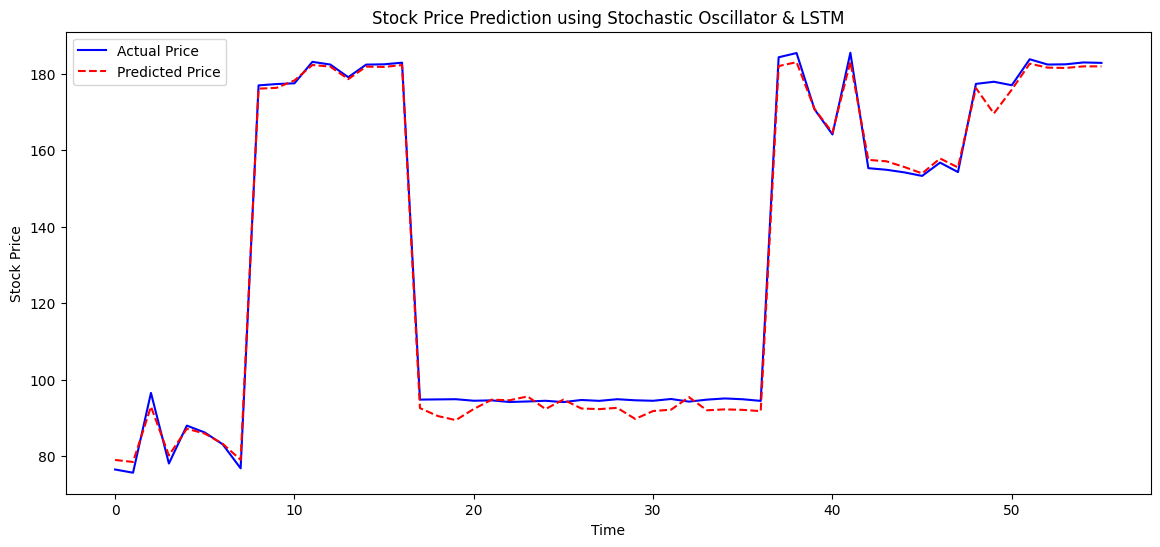

In [0]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

# Plot actual stock prices
plt.plot(test_pd.index, test_pd["close_price"], label="Actual Price", color="blue")

# Plot predicted stock prices
plt.plot(test_pd.index, test_pd["predicted_close"], label="Predicted Price", linestyle="dashed", color="red")

plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.title("Stock Price Prediction using Stochastic Oscillator & LSTM")
plt.legend()
plt.show()

#####  <p style="background-color:#070B19;font-family:TimesNewRoman;color:#81F7F3;font-size:100%;text-align:left;border-radius:15px 15px;padding:15px"> Store Predictions in Databricks Table ~ Gold </p>

In [0]:
from pyspark.sql import Row

# Convert predictions to PySpark DataFrame
predictions_df = spark.createDataFrame([
    Row(date=test_pd.index[i], actual_price=float(test_pd["close_price"][i]), predicted_price=float(test_pd["predicted_close"][i])) 
    for i in range(len(test_pd))
])

# Write predictions to Databricks Delta Table
predictions_df.write.mode("overwrite").format("delta").saveAsTable("gold.stock_predictions")